In [17]:
import tensorflow as tf
from tensorflow.keras import datasets ,layers,models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



In [19]:
from tensorflow import keras


In [3]:
data = pd.read_csv('Churn_Modelling.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [4]:
data.drop(["Surname","RowNumber","CustomerId"] ,axis=1 ,inplace=True)


## 📌 Explanation of Each Column in the Churn Modeling Dataset:

**CreditScore** → The customer's credit score (higher scores indicate more creditworthiness).

**Geography** → The country where the customer is located (e.g., France, Germany, Spain).

**Gender** → The gender of the customer (Male or Female).

**Age** → The customer's age in years.

**Tenure** → The number of years the customer has been with the bank.

**Balance** → The current account balance of the customer.

**NumOfProducts** → The number of banking products the customer is using (e.g., loans, accounts).

**HasCrCard** → Whether the customer has a credit card (1 = Yes, 0 = No).

**IsActiveMember** → Whether the customer is an active bank member (1 = Yes, 0 = No).

**EstimatedSalary** → The estimated salary of the customer.
Exited → Whether the customer has left the bank (1 = Yes, 0 = No).
 (Target variable for churn prediction).
## 🔹 "Exited" is the target variable for the classification model to predict customer churn.









In [5]:
data.isna().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [6]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
for col in numeric_columns:
    outliers = detect_outliers_iqr(data, col)
    print(f"{col}': {len(outliers)}")

CreditScore': 15
Age': 359
Tenure': 0
Balance': 0
NumOfProducts': 60
EstimatedSalary': 0


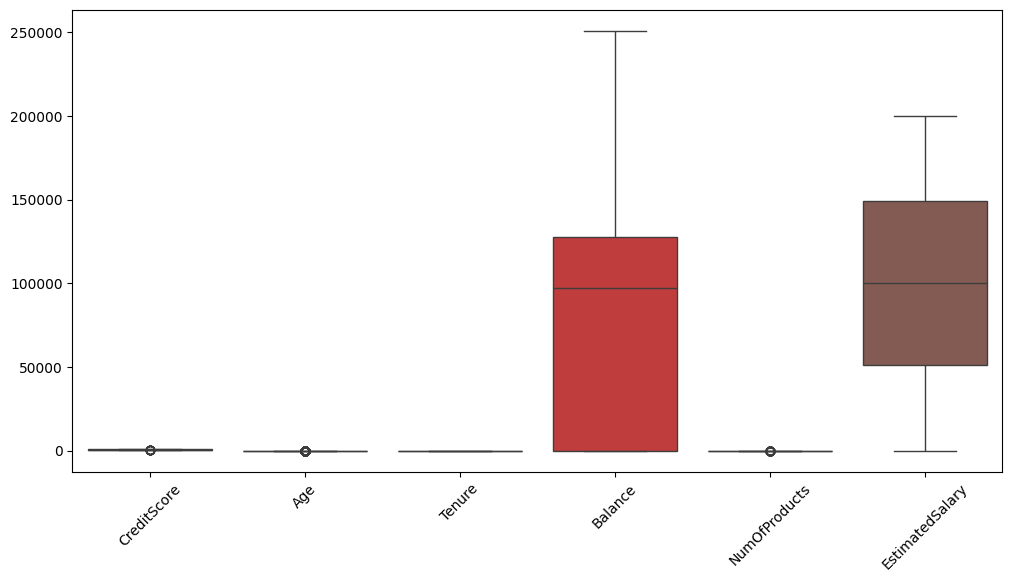

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=data[numeric_columns])
plt.xticks(rotation=45)
plt.show()


In [8]:
data.Age.describe()

,Age
count,10000.000000
mean,38.921800
std,10.487806
min,18.000000
25%,32.000000
50%,37.000000
75%,44.000000
max,92.000000


In [9]:
data.Age.median()

37.0

In [10]:
data.NumOfProducts.describe()

,NumOfProducts
count,10000.000000
mean,1.530200
std,0.581654
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,4.000000


In [11]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [13]:
data['Geography'] = labelencoder.fit_transform(data['Geography'])
data['Gender'] = labelencoder.fit_transform(data['Gender'])

In [14]:
X = data.drop('Exited', axis=1)
y = data['Exited']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5936 - loss: 3133.2178
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6943 - loss: 25.8995
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6841 - loss: 26.7254
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6843 - loss: 31.7385
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6812 - loss: 28.4953
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6830 - loss: 21.1272
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6749 - loss: 23.1426
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6810 - loss: 21.5646
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6858 - loss: 23.2565
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6959 - loss: 17.7895


In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6692 - loss: 106.8745
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6855 - loss: 54.6122
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6891 - loss: 53.2216
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6948 - loss: 67.9103
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6866 - loss: 55.8787
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6943 - loss: 37.9029
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6745 - loss: 48.7803
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6698 - loss: 36.9436
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6877 - loss: 49.1237
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6798 - loss: 43.3543


In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6544 - loss: 117.5747
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6836 - loss: 34.6547
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6958 - loss: 23.9892
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6778 - loss: 24.4488
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6817 - loss: 30.9573
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6755 - loss: 38.0272
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7053 - loss: 29.3858
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6997 - loss: 35.1925
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6851 - loss: 43.9235
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6898 - loss: 22.5483
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6801 - loss: 28.8622
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━

In [34]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6735 - loss: 624.3047
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6752 - loss: 86.9072
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6802 - loss: 55.3051
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6688 - loss: 52.1993
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6971 - loss: 39.0892
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6922 - loss: 31.4704
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6737 - loss: 31.7565
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6876 - loss: 22.5022
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6793 - loss: 13.6071
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6770 - loss: 15.8765
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6832 - loss: 12.2855
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━

In [36]:
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7968 - loss: 0.5050
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7905 - loss: 0.5141
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7933 - loss: 0.5093
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7918 - loss: 0.5113
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7951 - loss: 0.5068
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7996 - loss: 0.5008
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7943 - loss: 0.5078
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7959 - loss: 0.5055
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7976 - loss: 0.5079
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7988 - loss: 0.5004
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7967 - loss: 0.5045
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7971 - loss: 0.5049
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7961 - loss: 0.5056
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7924 - loss: 0.5106
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7913 - loss: 0.5120
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7921 - loss: 0.5142
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7972 - loss: 0.5043
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7922 - loss: 0.5108
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7938 - loss: 0.5091
Epoch 9/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7992 - loss: 0.5015
Epoch 10/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7922 - loss: 0.5220
Epoch 11/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7982 - loss: 0.5045
Epoch 12/100
250/250 ━━━━━━━━━━━━━━━━━━━━

In [41]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8026 - loss: 0.4972


[0.4963811933994293, 0.8034999966621399]

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50,batch_size=64)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7852 - loss: 0.5201
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7980 - loss: 0.5030
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7956 - loss: 0.5065
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7972 - loss: 0.5042
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.5075
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7998 - loss: 0.5007
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7988 - loss: 0.5021
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8034 - loss: 0.4962
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7930 - loss: 0.5101
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7908 - loss: 0.5129
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.5035
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [43]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8026 - loss: 0.4968


[0.49573737382888794, 0.8034999966621399]

In [49]:
model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50,batch_size=64)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8027 - loss: 0.4967
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7998 - loss: 0.5008
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7924 - loss: 0.5108
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7983 - loss: 0.5028
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7912 - loss: 0.5122
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7947 - loss: 0.5076
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8003 - loss: 0.5001
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7999 - loss: 0.5006
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7927 - loss: 0.5104
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7953 - loss: 0.5068
Epoch 11/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7947 - loss: 0.5075
Epoch 12/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [51]:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8026 - loss: 0.4967


[0.49556636810302734, 0.8034999966621399]